<a href="https://colab.research.google.com/github/seansothey/CSC685/blob/master/Project6_Unsupervised_Learning_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
# Common Import
import sklearn
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import os
import time

# to make this notebook's output stable across runs
np.random.seed(42)

from sklearn.decomposition import PCA
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore")

# sklearn version > 0.20 is required 
sklearn.__version__
# Update sklearn -> !pip install -U scikit-learn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'0.22.2.post1'

# Clustering Bridge Image Dataset

##Data Scrubing

## Loading Data

In [0]:
bridge = pd.read_csv('https://raw.githubusercontent.com/seansothey/CSC685/master/bridge.txt', delim_whitespace=True, header=None) #avoid spaces separated

In [3]:
bridge.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,6,8,6,9,0,0,0,0,0,0,0,0,0,0,0,0
1,7,4,3,4,0,0,0,0,0,0,0,0,0,0,0,0
2,8,8,8,18,31,12,22,34,74,74,68,60,96,99,104,79
3,9,9,16,34,11,15,38,54,60,22,65,75,99,78,92,114
4,9,19,34,39,23,26,31,39,16,31,34,41,59,63,33,38


In [4]:
bridge.shape

(4096, 16)

In [5]:
bridge.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
dtype: int64

In [0]:
bridge_np = np.array(bridge) #convert dataframe to numpy array

In [7]:
bridge_np

array([[  6,   8,   6, ...,   0,   0,   0],
       [  7,   4,   3, ...,   0,   0,   0],
       [  8,   8,   8, ...,  99, 104,  79],
       ...,
       [251, 247, 243, ..., 127, 141, 153],
       [252, 250, 249, ...,  92,  94,  99],
       [253, 224, 209, ..., 246, 233, 227]])

In [0]:
bridge4x4 = bridge_np.reshape(4096,4,4)

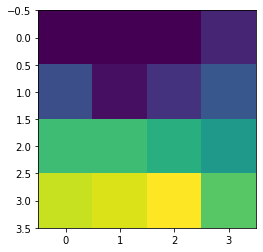

In [9]:
plt.imshow(bridge4x4[2]) #view the image index=2

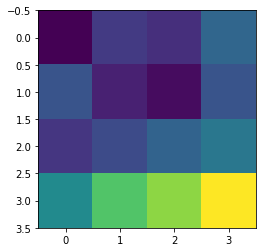

In [10]:
plt.imshow(bridge4x4[10]) #view the image index=10

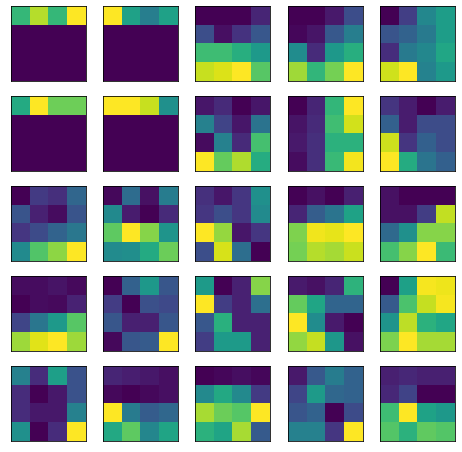

In [11]:
# See 25 images
plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(bridge4x4[i])

Text(0.5, 1.0, 'Bridge Dataset')

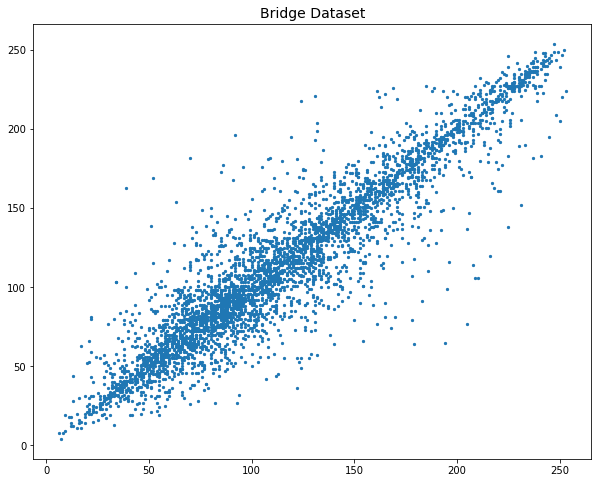

In [12]:
# See the whole dataset in 2d axis 
plt.figure(figsize=(10,8))
plt.scatter(bridge_np[:,0], bridge_np[:,1], s=5)
plt.title("Bridge Dataset", fontsize=14)

Generate isotropic Gaussian blobs for clustering

In [0]:
X_bridge, y_bridge = make_blobs(n_samples=len(bridge), random_state=42)

In [14]:
np.unique(y_bridge) #See how many labels was generated

array([0, 1, 2])

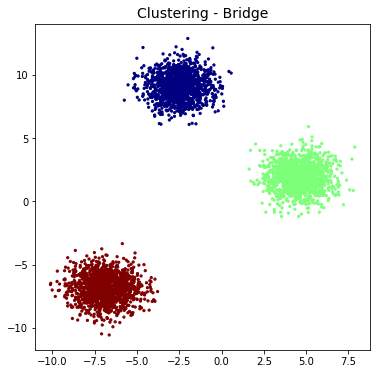

In [15]:
# Plot see the brief clusters 
plt.figure(figsize=(6,6))
plt.scatter(X_bridge[:, 0], X_bridge[:, 1], c=y_bridge, s=5, cmap='jet')
plt.title("Clustering - Bridge", fontsize=14)
plt.show()

Therefore, the number of clusters should be 3.

##Plot K-Elbow

In [0]:
kmeans=[KMeans(n_clusters=k, random_state=42).fit(X_bridge) for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans]

Text(0.5, 1.0, 'K - Elbow')

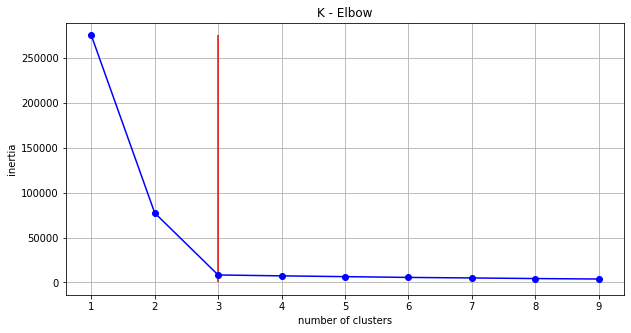

In [17]:
ax=plt.figure(figsize=(10,5))
plt.plot(range(1,10),inertias,"bo-")
plt.xlabel("number of clusters")
plt.ylabel("inertia")
plt.grid(True)
plt.vlines(3,0,np.max(inertias),color='red')
plt.title("K - Elbow")

As expected, the elbow point is k=3

## Plot the silhouette score vs performance of $k$

In [0]:
silhouette_scores = [silhouette_score(X_bridge, model.labels_)
                     for model in kmeans[1:]]
best_index = np.argmax(silhouette_scores)
best_score = silhouette_scores[best_index]
best_model = kmeans[best_index]

Text(0.5, 1.0, 'Performance of $K$')

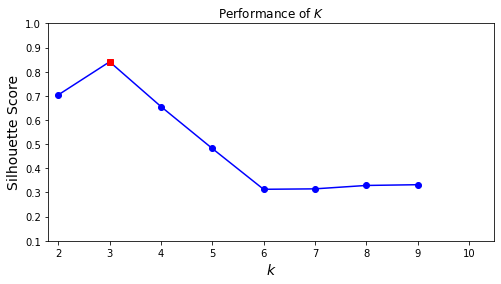

In [19]:
plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.plot(3, best_score, "rs")
plt.axis([1.8, 10.5, 0.1, 1.0])
plt.title("Performance of $K$")

This visualization is clear to confirms that $k=3$ is the best choice.

## K-Means Clustering

### Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [0]:
kmodel = KMeans(n_clusters=3, random_state=42)

In [0]:
y = kmodel.fit_predict(X_bridge)

In [22]:
y

array([2, 0, 0, ..., 2, 0, 0], dtype=int32)

In [23]:
len(y)

4096

In [24]:
y is kmodel.labels_

True

Therefore, y_pred is the label (0, 1, 2) tha represents for each cluster.

Note that the `KMeans` instance preserves the labels of the instances it was trained on. Somewhat confusingly, in this context, the _label_ of an instance is the index of the cluster that instance gets assigned to:

In [25]:
kmodel.labels_

array([2, 0, 0, ..., 2, 0, 0], dtype=int32)

Of course, we can predict the labels of new instances:

### Decision Boundaries

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:

In [0]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

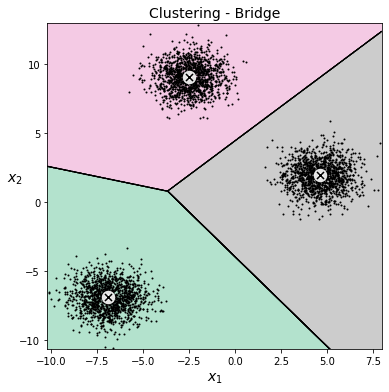

In [27]:
plt.figure(figsize=(6, 6))
plot_decision_boundaries(kmodel, X_bridge)
plt.title("Clustering - Bridge", fontsize=14)
plt.show()

##With RandomForest Classifier

## Spliting data for training and testing set in ratio 70%-30%

In [0]:
X_bridge_train, X_bridge_test, y_bridge_train, y_bridge_test = train_test_split(X_bridge, y, test_size=0.3, shuffle = True, random_state=42)

In [29]:
X_bridge_train.shape, X_bridge_test.shape, y_bridge_train.shape, y_bridge_test.shape

((2867, 2), (1229, 2), (2867,), (1229,))

Create the model and fit with the training set

In [30]:
from sklearn.ensemble import RandomForestClassifier

RF_bridge = RandomForestClassifier(random_state=42)
RF_bridge.fit(X_bridge_train, y_bridge_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Perform cross validation using subset size 500

In [31]:
cross_val_score(RF_bridge, X_bridge_train[:500], y_bridge_train[:500], cv=3, scoring='accuracy').mean()

1.0

Test the model using testing set

In [32]:
RF_bridge.score(X_bridge_test, y_bridge_test)

1.0

See the predict score

In [33]:
y_pred = RF_bridge.predict(X_bridge)
y_pred

array([2, 0, 0, ..., 2, 0, 0], dtype=int32)

In [34]:
accuracy_score(y, y_pred)

1.0

See the confustion matrix

In [0]:
labels = ['0', '1', '2']

Text(0.5, 1.0, 'Confusion Matrix')

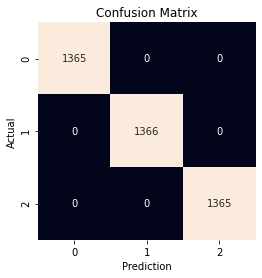

In [36]:
mat = confusion_matrix(y_pred, y)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

See how RF classify the first 25 images

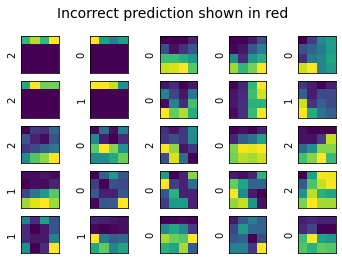

In [37]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(bridge4x4[i])
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(labels[y_pred[i]].split()[-1],
                   color='black' if y_pred[i] == y[i] else 'red')
fig.suptitle('Incorrect prediction shown in red', size=14);

There's no red number popup, that mean 100% rate prediction as expected.

##Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set

In [0]:
X_train_reduced = best_model.transform(X_bridge_train)
X_test_reduced = best_model.transform(X_bridge_test)

Perform cross validation using subset size 500

In [39]:
cross_val_score(RF_bridge, X_train_reduced[:500], y_bridge_train[:500], cv=3, scoring='accuracy').mean()

0.9020032224707212

Fit to training model

In [40]:
RF_bridge.fit(X_train_reduced, y_bridge_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Test the model using testing set

In [41]:
RF_bridge.score(X_test_reduced, y_bridge_test)

0.9023596419853539

The performance produce higher error when using K-Means as dimensionality reduction.

## Search for the number of clusters that provides the best performance.

In [42]:
from sklearn.pipeline import Pipeline

for n_clusters in range(1,11):
    pipe_bridge = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    pipe_bridge.fit(X_bridge_train, y_bridge_train)
    print(n_clusters, pipe_bridge.score(X_bridge_test, y_bridge_test))

1 0.6517493897477624
2 0.8966639544344996
3 1.0
4 1.0
5 1.0
6 1.0
7 1.0
8 1.0
9 1.0
10 1.0


## This can be seen clearly that, n_clusters = 3 provides the best performance.

##With Gaussian Mixtures

Apply PCA (99% variataion)

In [0]:
pca = PCA(0.99)
X_bridge_pca = pca.fit_transform(X_bridge)

Let's train a Gaussian mixture model on the training set

In [44]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X_bridge_pca)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Let's look at the parameters that the EM algorithm estimated:

In [45]:
gm.weights_

array([0.33325195, 0.33349609, 0.33325195])

In [46]:
gm.means_

array([[ 9.76841849, -1.04822152],
       [-6.49080233, -4.23657971],
       [-3.27286099,  5.28790496]])

Did the algorithm actually converge?

In [47]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [48]:
gm.n_iter_

2

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster.

In [49]:
gm.predict(X_bridge_pca)

array([2, 0, 0, ..., 2, 0, 0])

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [0]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

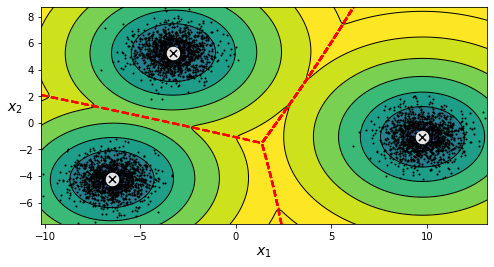

In [51]:
plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X_bridge_pca)
plt.show()

## Anomaly Detection using Gaussian Mixtures

Gaussian Mixtures can be used for _anomaly detection_: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [0]:
densities = gm.score_samples(X_bridge_pca)
density_threshold = np.percentile(densities, 4)
anomalies = X_bridge_pca[densities < density_threshold]

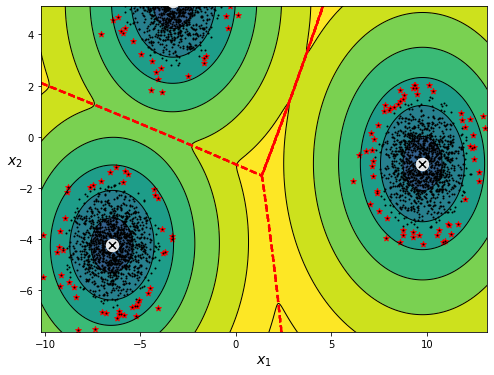

In [53]:
plt.figure(figsize=(8, 6))

plot_gaussian_mixture(gm, X_bridge_pca)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)
plt.show()

# Clustering Coil-100 Image Dataset

##Data Scrubing

## Loading Data

Download Coil100 from Sean Kaggle

In [0]:
import os
import tarfile
import random
from zipfile import ZipFile
import cv2
from google.colab.patches import cv2_imshow
import urllib
import urllib.parse as parse

In [0]:
def download(url,save_path,target_file_name=''):
  print("file is being downloading from {} ...".format(url))
  file = urllib.request.urlopen(url)
  fileData = file.read()

  if target_file_name=='':
    split=parse.urlsplit(url)
    target_file_name = split.path.split('/')[-1]
  
  if not os.path.exists(save_path):
    os.mkdir(save_path)

  targetFile = os.path.join(save_path,target_file_name)
  with open(targetFile,'wb') as f:
    f.write(fileData)
  print('Done, file in the path {}'.format(targetFile))

In [0]:
def extractTar(tar_file_path,target_path):
    print("Start extracting....")
    tar=tarfile.open(tar_file_path)
    tar.extractall(target_path)
    tar.close()
    print("Done")

In [0]:
def extractZip(tar_file_path,target_path):
    print("Start extracting....")
    zFile=ZipFile(tar_file_path)
    zFile.extractall(target_path)
    zFile.close()
    print("Done")

In [0]:
root_path = 'data'
os.mkdir(root_path)

In [59]:
download('https://storage.googleapis.com/kaggle-data-sets/589973/1063434/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586506868&Signature=OeomkNazrVOV6QMP6sd%2BMUJITjJSg0lk5tIpWhJOwU4c4VCK7E3PxxEKlovk4x8XBGKmtL90cQUy5BoQSo%2BdulwmSx41RqZYkRHPMyvhgydFX0wAol%2Fy75828DdowN37isM04sYFTD4PleKuj7hD95bFWvv1mKSh0w%2BIZAEaMsS6bOvqPpXkJYN1G8mffLUFWpKGklEX6Y4ERiMGhIlQBp9RH1WHAYSyoreld0g02%2FkrVzub8i%2B9D1sOPfG%2F8VfXgxyVoACA2lSRJycZ7me2wuAmBLx%2FlhivpHI2dLZ%2BBymxtmxhvDnDioxDl7wwQqYqy9MMUAlXPZPvlMJ%2Baf%2FaLQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dcoil100.zip',os.path.join(root_path,'coil100'),'coil100.zip')

file is being downloading from https://storage.googleapis.com/kaggle-data-sets/589973/1063434/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586506868&Signature=OeomkNazrVOV6QMP6sd%2BMUJITjJSg0lk5tIpWhJOwU4c4VCK7E3PxxEKlovk4x8XBGKmtL90cQUy5BoQSo%2BdulwmSx41RqZYkRHPMyvhgydFX0wAol%2Fy75828DdowN37isM04sYFTD4PleKuj7hD95bFWvv1mKSh0w%2BIZAEaMsS6bOvqPpXkJYN1G8mffLUFWpKGklEX6Y4ERiMGhIlQBp9RH1WHAYSyoreld0g02%2FkrVzub8i%2B9D1sOPfG%2F8VfXgxyVoACA2lSRJycZ7me2wuAmBLx%2FlhivpHI2dLZ%2BBymxtmxhvDnDioxDl7wwQqYqy9MMUAlXPZPvlMJ%2Baf%2FaLQ%3D%3D&response-content-disposition=attachment%3B+filename%3Dcoil100.zip ...
Done, file in the path data/coil100/coil100.zip


In [60]:
extractZip('data/coil100/coil100.zip', 'data/coil100/imgs')

Start extracting....
Done


In [0]:
coil_100 = os.listdir('data/coil100/imgs/coil-100')

In [63]:
len(coil_100)

7202

In [0]:
# Remove files that are not image
for item in coil_100:
    if not item.endswith('.png'):
        os.remove((coil_100, item))

In [75]:
len(coil_100)

7202

In [0]:
# Plot to see some images of the dataset
for i in range(10):
  rndIndx = random.randint(0,len(coil_100)-1)
  img = cv2.imread(os.path.join('data/coil100/imgs/coil-100',coil_100[rndIndx]))
  cv2_imshow(img)


Generate isotropic Gaussian blobs for clustering

In [0]:
X_coil100, y_coil100 = make_blobs(n_samples=len(coil_100), random_state=42, )

In [99]:
X_coil100.shape, y_coil100.shape

((7202, 2), (7202,))

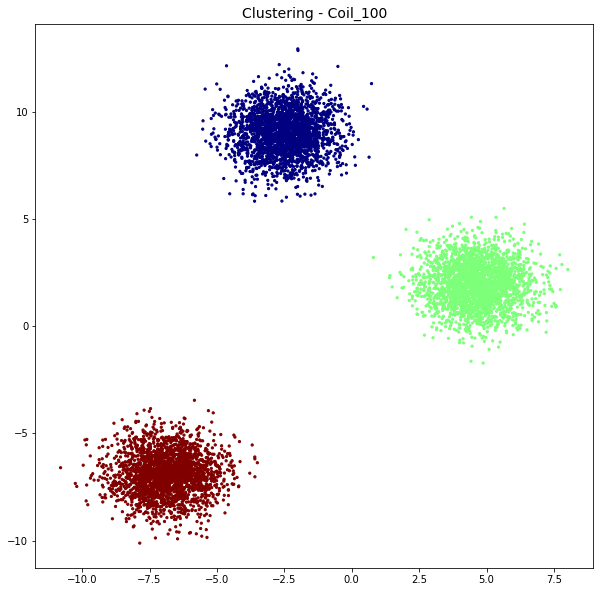

In [121]:
# Plot see the brief clusters 
plt.figure(figsize=(10,10))
plt.scatter(X_coil100[:, 0], X_coil100[:, 1], c=y_coil100, s=5, cmap='jet')
plt.title("Clustering - Coil_100", fontsize=14)
plt.show()

Therefore, the number of clusters should be 3.

##Plot K-Elbow

In [0]:
kmeans =[KMeans(n_clusters=k, random_state=42).fit(X_coil100) for k in range(10,150,10)]
inertias = [model.inertia_ for model in kmeans]

Text(0.5, 1.0, 'K - Elbow')

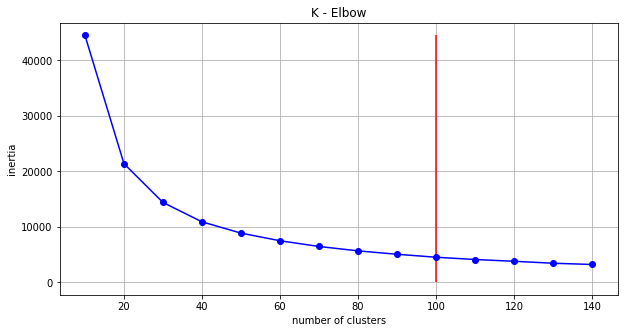

In [102]:
ax=plt.figure(figsize=(10,5))
plt.plot(range(10,150,10),inertias,"bo-")
plt.xlabel("number of clusters")
plt.ylabel("inertia")
plt.grid(True)
plt.vlines(100,0,np.max(inertias),color='red')
plt.title("K - Elbow")

###The elbow point is k=100

## K-Means Clustering

### Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [0]:
kmodel = KMeans(n_clusters=100, random_state=42)

In [0]:
y = kmodel.fit_predict(X_coil100)

In [105]:
y

array([99,  6, 59, ..., 17, 57, 73], dtype=int32)

In [106]:
len(y)

7202

In [107]:
y is kmodel.labels_

True

Therefore, y is the label (1, 2,..,100) tha represents for each cluster.

### Decision Boundaries

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:

In [0]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

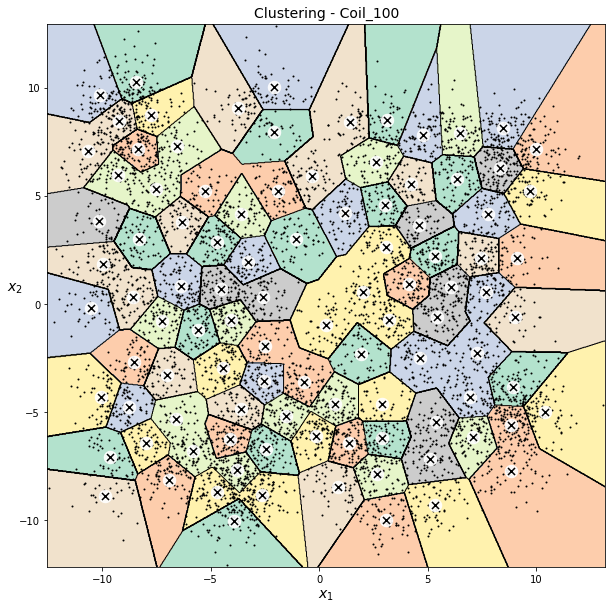

In [109]:
plt.figure(figsize=(10, 10))
plot_decision_boundaries(kmodel, X_coil100)
plt.title("Clustering - Coil_100", fontsize=14)
plt.show()

##With RandomForest Classifier

## Spliting data for training and testing set in ratio 70%-30%

In [0]:
X_coil100_train, X_coil100_test, y_coil100_train, y_coil100_test = train_test_split(X_coil100, y, test_size=0.3, shuffle = True, random_state=42)

In [111]:
X_coil100_train.shape, X_coil100_test.shape, y_coil100_train.shape, y_coil100_test.shape

((5041, 2), (2161, 2), (5041,), (2161,))

Create the model and fit with the training set

In [112]:
from sklearn.ensemble import RandomForestClassifier

RF_bridge = RandomForestClassifier(random_state=42)
RF_bridge.fit(X_coil100_train, y_coil100_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Perform cross validation using subset size 500

In [113]:
cross_val_score(RF_bridge, X_coil100[:500], y[:500], cv=3, scoring='accuracy').mean()

0.7580020681528509

Test the model using testing set

In [114]:
RF_bridge.score(X_coil100_test, y_coil100_test)

0.94447015270708

See the predict score

In [115]:
y_pred = RF_bridge.predict(X_coil100)
y_pred

array([99,  6, 59, ..., 17, 57, 73], dtype=int32)

In [116]:
accuracy_score(y, y_pred)

0.9833379616773119

See the confustion matrix

In [0]:
labels = str(np.arange(1, 101).tolist())

Text(0.5, 1.0, 'Confusion Matrix')

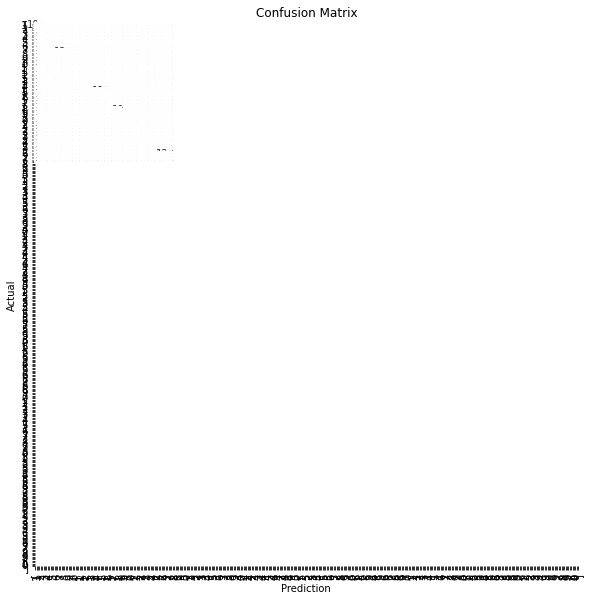

In [118]:
fig, ax = plt.subplots(figsize=(10,10)) 
mat = confusion_matrix(y_pred, y)
sns.heatmap(mat.T, square=True, annot=True,fmt='d',
            cbar=False, ax=ax,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Prediction')
plt.ylabel('Actual');
plt.title('Confusion Matrix')

See how RF classify the first 25 images

TypeError: ignored

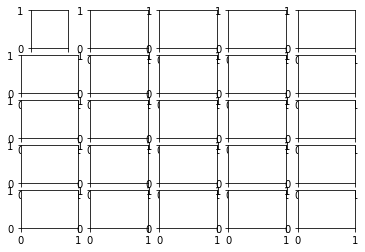

In [137]:
fig, ax = plt.subplots(5, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(os.path.join('data/coil100/imgs/coil-100', coil_100[i]))
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(labels[y_pred[i]].split()[-1],
                   color='black' if y_pred[i] == y[i] else 'red')
fig.suptitle('Incorrect prediction shown in red', size=14);

There's no red number popup, that mean 100% rate prediction as expected.

##Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set

In [0]:
X_train_coil100_reduced = best_model.transform(X_coil100_train)
X_test_coil100_reduced = best_model.transform(X_coil100_test)

Perform cross validation using subset size 500

In [123]:
cross_val_score(RF_bridge, X_train_coil100_reduced[:500], y_coil100_train[:500], cv=3, scoring='accuracy').mean()

0.5919847052882189

Fit to training model

In [124]:
RF_bridge.fit(X_train_coil100_reduced, y_coil100_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Test the model using testing set

In [125]:
RF_bridge.score(X_test_coil100_reduced, y_coil100_test)

0.6621934289680703

The performance produce higher error when using K-Means as dimensionality reduction.

## Search for the number of clusters that provides the best performance.

In [136]:
from sklearn.pipeline import Pipeline

for n_clusters in range(10,150,10):
    pipe = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    pipe.fit(X_coil100_train, y_coil100_train)
    print(n_clusters, pipe.score(X_coil100_test, y_coil100_test))

10 0.957427117075428
20 0.967144840351689
30 0.963442850532161
40 0.970846830171217
50 0.965756594169366
60 0.963442850532161
70 0.96760758907913
80 0.965756594169366
90 0.9648310967144841
100 0.96760758907913
110 0.968533086534012
120 0.9699213327163351
130 0.968533086534012
140 0.966682091624248


### All n_clusters provides similar erformance.

##With Gaussian Mixtures

Apply PCA (99% variataion)

In [0]:
pca = PCA(0.99)
X_pca = pca.fit_transform(X_coil100)

Let's train a Gaussian mixture model on the training set

In [128]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=100, n_init=10, random_state=42)
gm.fit(X_pca)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=100, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

Did the algorithm actually converge?

In [129]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [130]:
gm.n_iter_

9

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster. For this, just use `predict()` method or the `predict_proba()` method:

In [131]:
gm.predict(X_pca)

array([40, 20, 96, ..., 39, 26, 70])

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [0]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

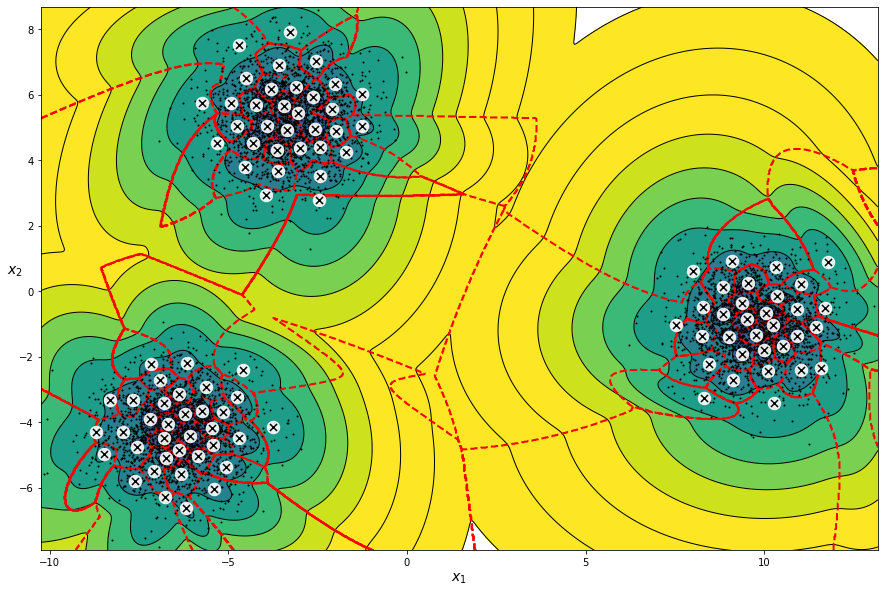

In [133]:
plt.figure(figsize=(15, 10))
plot_gaussian_mixture(gm, X_pca)
plt.show()

## Anomaly Detection using Gaussian Mixtures

Assume the threshold is 10%

In [0]:
densities = gm.score_samples(X_pca)
density_threshold = np.percentile(densities, 10)
anomalies = X_pca[densities < density_threshold]

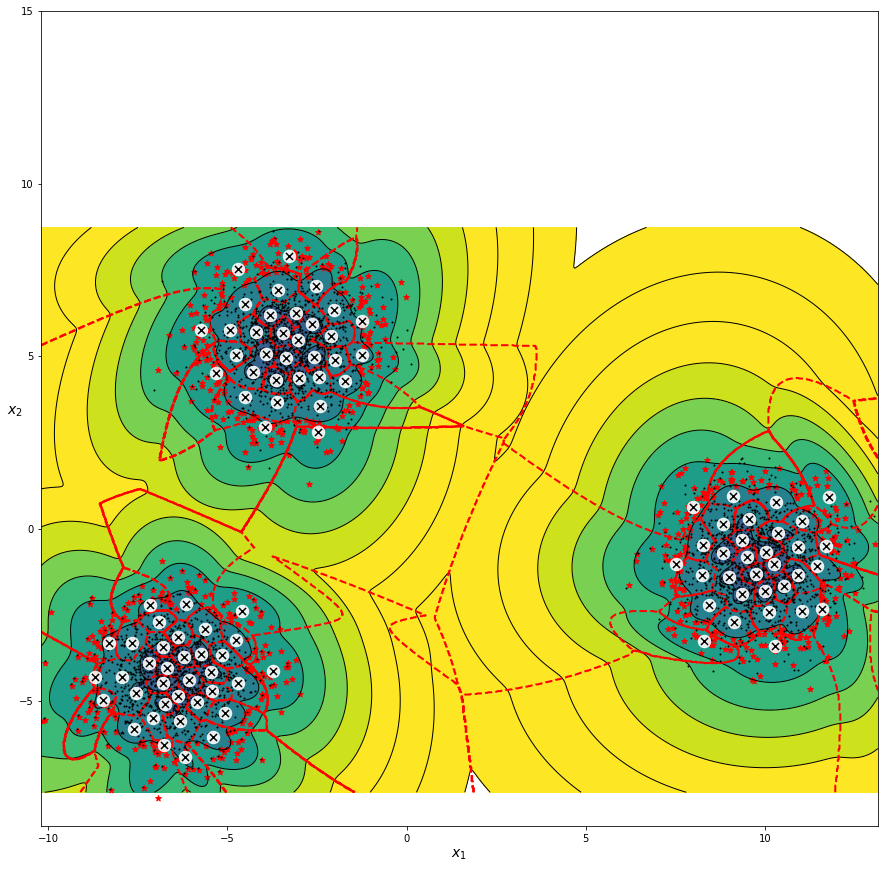

In [135]:
plt.figure(figsize=(15, 15))

plot_gaussian_mixture(gm, X_bridge_pca)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=15)
plt.show()